In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pm25-on-18082023/PM.csv
/kaggle/input/pm25-on-18082023/Sensor.csv


# **Environment Setup**

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Import The dataset**

This is the sensors and its pollution measurements of ever sensors in Thailand regarding to CUSENSE.NET API of October 18th, 2023. Now, We have **import the data** to the environment and **pre-processing them.**

In [4]:
pm = pd.read_csv('/kaggle/input/pm25-on-18082023/PM.csv')
sen = pd.read_csv('/kaggle/input/pm25-on-18082023/Sensor.csv')

In [5]:
pm

,Sensor,Time,PM2.5,PM10,Temp,Humid
0,cusensor2/0424D01F9C9C,2023-08-18T14:00:00.000Z,0,1.0,29.4,55.0
1,cusensor2/0C44F5C40A24,2023-08-18T14:00:00.000Z,2,7.0,33.4,47.0
2,cusensor2/40F5203F0828,2023-08-18T14:00:00.000Z,3,8.0,26.9,78.0
3,cusensor2/40F5203F7FBF,2023-08-18T14:00:00.000Z,2,6.0,29.1,43.0
4,cusensor2/40F5203F88E0,2023-08-18T14:00:00.000Z,2,7.0,26.2,62.0
...,...,...,...,...,...,...
246,nansensor/CU-S0079,2023-08-18T14:00:00.000Z,6,7.0,34.8,55.0
247,nansensor/CU-S0081,2023-08-18T14:00:00.000Z,8,8.0,35.9,60.0
248,nansensor/CU-S0085,2023-08-18T14:00:00.000Z,6,7.0,36.6,59.0
249,nansensor/CU-S0098,2023-08-18T14:00:00.000Z,10,10.0,36.1,60.0


In [6]:
sen

,Sensor,Name,Lat,Lon,Prov
0,cusensor/CU-01,"ภาควิชาวิศวกรรมสิ่งแวดล้อม, จุฬา",13.735661,100.532588,กรุงเทพ
1,cusensor/CU-S0203,Institute of Technology of Cambodia (ITC),11.570522,104.896714,Phnom Penh
2,cusensor/MET.SK.TEEGA,ฝายตีกา,14.918769,104.137828,ศรีสะเกษ
3,cusensor/RKN-001,Resident House (RS),11.580575,104.930686,Phnom Penh
4,cusensor/RKN-002,Phnom Penh Special Economic Zone (PPSEZ),11.476056,104.784333,Phnom Penh
...,...,...,...,...,...
1247,sensor4all/868333032109270,คุณสายชล สันเขื่อนสิริกิติ์,17.767062,100.566225,NaN
1248,sensor4all/868333032109486,ร้านจ่าจ้า คอฟฟี่,9.956770,98.639105,NaN
1249,sensor4all/868333032109833,สำนักงานพลังงานจังหวัดราชบุรี,13.570139,99.730514,NaN
1250,sensor4all/868333032109965,โรงเรียนสงวนหญิง,14.484932,100.123852,NaN


In [7]:
# count for unique amount of sensors
sen['Sensor'].nunique()

1252

In [8]:
sen['Prov'].value_counts()

น่าน          125
กรุงเทพ        53
Phnom Penh      4
ลำพูน           2
ศรีสะเกษ        1
สมุทรสาคร       1
เชียงใหม่       1
ระยอง           1
Name: Prov, dtype: int64

# **Preprocessing Data**

First, we have to join two datasets we have with primary keys (Sensor) to create one table with all columns merging.

In [9]:
merge = pd.merge(pm, sen, on="Sensor", how = 'outer')

In [10]:
merge

,Sensor,Time,PM2.5,PM10,Temp,Humid,Name,Lat,Lon,Prov
0,cusensor2/0424D01F9C9C,2023-08-18T14:00:00.000Z,0.0,1.0,29.4,55.0,จามจุรี 5 ชั้น 3,13.738300,100.528816,กรุงเทพ
1,cusensor2/0C44F5C40A24,2023-08-18T14:00:00.000Z,2.0,7.0,33.4,47.0,จามจุรี 10 ชั้น 11,13.742675,100.528077,กรุงเทพ
2,cusensor2/40F5203F0828,2023-08-18T14:00:00.000Z,3.0,8.0,26.9,78.0,ห้องปฏิบัติการเคมี สถาบันวิจัยสภาวะแวดล้อม (In...,13.742930,100.532150,กรุงเทพ
3,cusensor2/40F5203F7FBF,2023-08-18T14:00:00.000Z,2.0,6.0,29.1,43.0,ภาควิชาเคมีเทคนิค ชั้น ห้อง 1810 อาคารมหามกุฎ ...,13.736020,100.530590,กรุงเทพ
4,cusensor2/40F5203F88E0,2023-08-18T14:00:00.000Z,2.0,7.0,26.2,62.0,EDS Program (Indoor),13.742830,100.528250,กรุงเทพ
...,...,...,...,...,...,...,...,...,...,...
1247,sensor4all/868333032109270,NaN,NaN,NaN,NaN,NaN,คุณสายชล สันเขื่อนสิริกิติ์,17.767062,100.566225,NaN
1248,sensor4all/868333032109486,NaN,NaN,NaN,NaN,NaN,ร้านจ่าจ้า คอฟฟี่,9.956770,98.639105,NaN
1249,sensor4all/868333032109833,NaN,NaN,NaN,NaN,NaN,สำนักงานพลังงานจังหวัดราชบุรี,13.570139,99.730514,NaN
1250,sensor4all/868333032109965,NaN,NaN,NaN,NaN,NaN,โรงเรียนสงวนหญิง,14.484932,100.123852,NaN


Now, we got our merge dataset.
In the next step, we will focus on data cleaning process. dealing with null data, duplicate, unusual formatting etc.

In [11]:
# extract only valid pm data from station - handling missing data
merge1 = merge.loc[merge['PM2.5'].isnull() == False]
merge2 = merge1.loc[merge['PM10'].isnull() == False]

In [12]:
merge2

,Sensor,Time,PM2.5,PM10,Temp,Humid,Name,Lat,Lon,Prov
0,cusensor2/0424D01F9C9C,2023-08-18T14:00:00.000Z,0.0,1.0,29.4,55.0,จามจุรี 5 ชั้น 3,13.738300,100.528816,กรุงเทพ
1,cusensor2/0C44F5C40A24,2023-08-18T14:00:00.000Z,2.0,7.0,33.4,47.0,จามจุรี 10 ชั้น 11,13.742675,100.528077,กรุงเทพ
2,cusensor2/40F5203F0828,2023-08-18T14:00:00.000Z,3.0,8.0,26.9,78.0,ห้องปฏิบัติการเคมี สถาบันวิจัยสภาวะแวดล้อม (In...,13.742930,100.532150,กรุงเทพ
3,cusensor2/40F5203F7FBF,2023-08-18T14:00:00.000Z,2.0,6.0,29.1,43.0,ภาควิชาเคมีเทคนิค ชั้น ห้อง 1810 อาคารมหามกุฎ ...,13.736020,100.530590,กรุงเทพ
4,cusensor2/40F5203F88E0,2023-08-18T14:00:00.000Z,2.0,7.0,26.2,62.0,EDS Program (Indoor),13.742830,100.528250,กรุงเทพ
...,...,...,...,...,...,...,...,...,...,...
245,nansensor/CU-S0071,2023-08-18T14:00:00.000Z,0.0,0.0,37.4,49.0,องค์การบริหารส่วนจังหวัดน่าน,18.799662,100.733299,น่าน
246,nansensor/CU-S0079,2023-08-18T14:00:00.000Z,6.0,7.0,34.8,55.0,องค์การบริหารส่วนตำบลสันทะ,18.300600,100.594360,น่าน
247,nansensor/CU-S0081,2023-08-18T14:00:00.000Z,8.0,8.0,35.9,60.0,องค์การบริหารส่วนตำบลดุ่พงษ์,18.910000,100.940000,น่าน
248,nansensor/CU-S0085,2023-08-18T14:00:00.000Z,6.0,7.0,36.6,59.0,องค์การบริหารส่วนตำบลถืมตอง,18.797941,100.714249,น่าน


We see that PM2.5 data is gathered by some provinces mostly in Nan and Bangkok. So, in the next process, the analysis will consider this condition.

In [13]:
# check for types
merge2.dtypes

Sensor     object
Time       object
PM2.5     float64
PM10      float64
Temp      float64
Humid     float64
Name       object
Lat       float64
Lon       float64
Prov       object
dtype: object

replace Nan Humidity Values with its average

In [14]:
merge2['Humid'] = merge2['Humid'].fillna(round(merge2['Humid'].mean(),1))

# **Checking its distribution of every features**

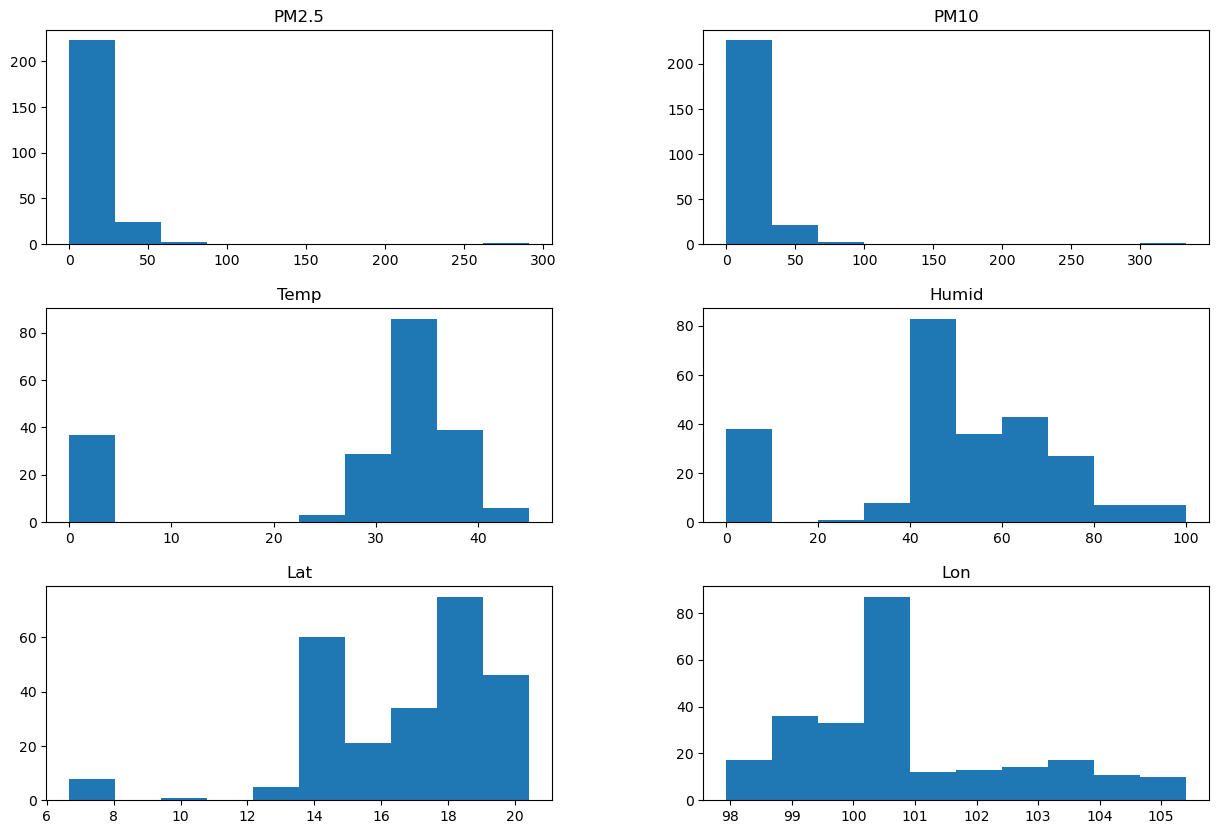

In [15]:
merge2.hist(bins=10,figsize=(15,10),grid=False);

Let see which are **top five the most polluted and the least polluted areas.** (PM2.5)

In [16]:
Top5 = merge2.sort_values(by='PM2.5', ascending=False).head(5)
Top5

,Sensor,Time,PM2.5,PM10,Temp,Humid,Name,Lat,Lon,Prov
177,Dustboy/5302,2023-08-18T14:00:00.000Z,291.0,333.0,33.0,95.0,รพ.สต. บ้านดงมะตื๋น (บ้านดงมะตื๋นใหม่ หมู่ 15),19.916302,100.040937,NaN
16,cusensor3/240AC4588CF8,2023-08-18T14:00:00.000Z,80.0,92.0,30.7,82.0,โรงเรียนสา (1),18.560438,100.752007,น่าน
204,Dustboy/5401,2023-08-18T14:00:00.000Z,61.0,77.0,NaN,48.8,อบต.ศรีถ้อย อ.แม่สรวย จ.เชียงราย (กอ.รมน. เชีย...,19.614124,99.478223,NaN
175,Dustboy/5300,2023-08-18T14:00:00.000Z,51.0,54.0,35.0,69.0,โรงพยาบาลโซ่พิสัย,18.081075,103.447313,NaN
45,cusensor3/B8F009CD07DC,2023-08-18T14:00:00.000Z,42.0,48.0,30.8,78.0,โรงเรียนบ้านนาวงศ์,19.168417,100.828003,น่าน


In [17]:
Least5 = merge2.sort_values(by='PM2.5', ascending=True).head(5)
Least5

,Sensor,Time,PM2.5,PM10,Temp,Humid,Name,Lat,Lon,Prov
0,cusensor2/0424D01F9C9C,2023-08-18T14:00:00.000Z,0.0,1.0,29.4,55.0,จามจุรี 5 ชั้น 3,13.738300,100.528816,กรุงเทพ
43,cusensor3/8CAAB5852984,2023-08-18T14:00:00.000Z,0.0,0.0,33.2,48.0,ทต.ก้อ,17.639110,98.785331,ลำพูน
41,cusensor3/8CAAB5851AD4,2023-08-18T14:00:00.000Z,0.0,0.0,29.6,59.0,อุทยานแห่งชาติแม่ปิง,17.669825,98.869539,ลำพูน
20,cusensor3/240AC4C656F8,2023-08-18T14:00:00.000Z,0.0,0.0,36.4,54.0,วิทยนิเวศน์,13.740698,100.527156,กรุงเทพ
245,nansensor/CU-S0071,2023-08-18T14:00:00.000Z,0.0,0.0,37.4,49.0,องค์การบริหารส่วนจังหวัดน่าน,18.799662,100.733299,น่าน


linear correlations of the data

/tmp/ipykernel_20/2237375264.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = merge2.corr()


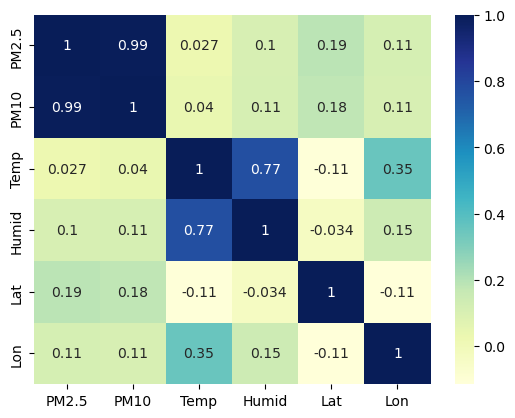

In [18]:
cor = merge2.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

We see that the humidity doesn't affect the pollution much. The latitude tend to be. The analysis with mainly focus on the correlation between them by creating different **Linear Regression Models.**  

# **Model Creating**

The model we use in this notebook are:
* Linear Regression Model
* XGBoost

**Linear Regression Model (Sklearn)**

In [19]:
# extract features (sigificant) amd target
x = merge2[['Lat','Lon','Humid']]
y = merge2["PM2.5"]
print(x.shape)
print(y.shape)

(250, 3)
(250,)


In [20]:
from sklearn.model_selection import train_test_split
#testing data size is of 33% of entire data
x_train, x_test, y_train, y_test =train_test_split(x,y, test_size=0.33, random_state=5)

In [21]:
x_train

,Lat,Lon,Humid
202,19.441691,98.984482,48.8
50,18.775246,100.687514,72.0
23,13.742292,100.533517,61.0
1,13.742675,100.528077,47.0
87,19.511812,98.514438,0.0
...,...,...,...
230,18.761371,98.931855,0.0
189,13.267923,99.592925,48.8
239,19.208550,101.185284,64.0
206,19.167872,100.284061,48.8


In [22]:
from sklearn.linear_model import LinearRegression
#fitting our model to train and test
lm = LinearRegression()
model = lm.fit(x_train,y_train)

In [23]:
print(x.columns)
print(model.intercept_)
print(model.coef_)

Index(['Lat', 'Lon', 'Humid'], dtype='object')
-155.41559194129474
[1.88361578 1.30825521 0.12529853]


**PM2.5 = 1.88348022(LAT) + 1.30816118(LON) + 0.12530796(Humid) - 155.40343619788888**

In [24]:
y_pred = model.predict(x_test)

Result Representation

In [25]:
pd.DataFrame({"Actual": y_test, "Predict": y_pred}).head()

,Actual,Predict
93,6.0,20.058808
153,8.0,8.688524
199,9.0,17.524822
88,1.0,18.700190
185,27.0,10.327485


The prediction result is not that promising since we see that there is a liitle correlation between those features and target.

Text(0, 0.5, 'Predicted Y')

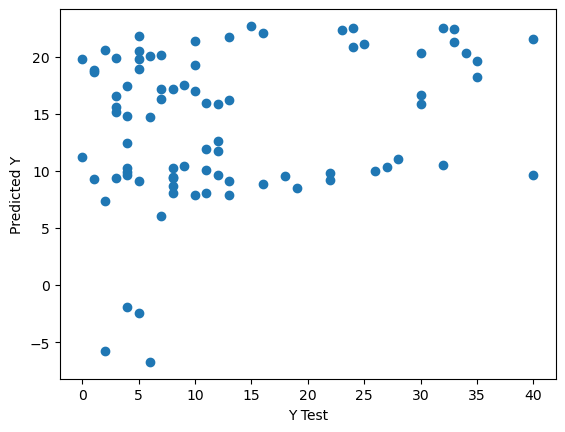

In [26]:
plt.scatter(y_test,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

Evaluation

In [27]:
# calculate RMSE
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(math.sqrt(mse))
print(y_test.mean())

11.054863121080608
13.096385542168674


**RMSE = 11.054737952424535** not that good, right? Let see if XGBoost can do it better.

 **XGBoost**

In [28]:
# create an xgboost regression model
from xgboost import XGBRegressor
model = XGBRegressor(objective ='reg:linear',
                  n_estimators = 1, seed = 1)
# Fitting the model
model.fit(x_train, y_train)
  
# Predict the model
pred = model.predict(x_test)
  
# RMSE Computation
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

[04:52:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  13.662201


**RMSE = 13.662201** a little bit higher than Basic Linear Regression.